In [1]:
# WHAT DO WE WANT FROM THIS NOTEBOOK:
# - See distributions for different metrics
# - See averages and deviations for different metrics
# - See distributions for different team subsets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Get NBA data
playerData = pd.read_csv('NBAPlayerData/Players.csv')
playerStats = pd.read_csv('NBAPlayerData/Seasons_Stats.csv')

playerStats.rename(columns={'G':"gamesPlayed"}, inplace=True)

# Get the players that play since 2000
playerStats = playerStats[playerStats['Year']>=2000]
# Only look at players who have played more than 20 games
playerStats = playerStats[playerStats["gamesPlayed"]>30]
# Only look at players who have played more than minutes
playerStats = playerStats[playerStats["MP"]>300]
playerData = playerData[playerData['Player'].isin(playerStats['Player'])]

# Merge the datasets
playerStats = playerStats.merge(playerData, on="Player")

# Make some of the columns we need
playerStats['PPG'] = playerStats['PTS']/playerStats['gamesPlayed']
playerStats['PPM'] = playerStats['PTS']/playerStats['MP']
playerStats['AST_per_TOV'] = [playerStats['AST'].iloc[i]/playerStats['TOV'].iloc[i] if playerStats['TOV'].iloc[i]!=0 else np.nan for i in range(len(playerStats))]
playerStats['MP_per_PF'] = [playerStats["PF"].iloc[i]/playerStats["MP"].iloc[i] if playerStats['MP'].iloc[i]!=0 else np.nan for i in range(len(playerStats))]
playerStats['FTA_per_FGA'] = [playerStats["FTA"].iloc[i]/playerStats["FGA"].iloc[i] if playerStats['FGA'].iloc[i]!=0 else np.nan for i in range(len(playerStats))]
playerStats['MP_per_3PA'] = [playerStats["MP"].iloc[i]/playerStats["3PA"].iloc[i] if playerStats['3PA'].iloc[i]!=0 else np.nan for i in range(len(playerStats))]
playerStats['PTS_per_FGA'] = [playerStats["PTS"].iloc[i]/playerStats["FGA"].iloc[i] if playerStats['FGA'].iloc[i]!=0 else np.nan for i in range(len(playerStats))]

# Rename some columns
playerStats.rename(columns={"weight":"WEIGHT", "height":"HEIGHT"}, inplace=True)

# Fix some team names
playerStats.replace("NJN", "BRK", inplace=True)
playerStats.replace("NOH", "NOP", inplace=True)
playerStats.replace("CHA", "CHO", inplace=True)
playerStats.replace("CHH", "CHO", inplace=True)
playerStats.replace("VAN", "MEM", inplace=True)
playerStats.replace("SEA", "OKC", inplace=True)
playerStats.replace("NOK", "NOP", inplace=True)

# Drop players that got traded that season
playerStats = playerStats[playerStats.Tm!='TOT']

# Create the position columns
playerStats["G"] = [1 if "G" in playerStats['Pos'].iloc[i] else 0 for i in range(len(playerStats))]
playerStats["F"] = [1 if "F" in playerStats['Pos'].iloc[i] else 0 for i in range(len(playerStats))]
playerStats["C"] = [1 if "C" in playerStats['Pos'].iloc[i] else 0 for i in range(len(playerStats))]

# Fill in missing values
playerStats["3P%"] = playerStats['3P%'].fillna(0)
playerStats["FT%"] = playerStats['FT%'].fillna(0)
playerStats["MP_per_3PA"] = playerStats['MP_per_3PA'].fillna(np.mean(playerStats['MP_per_3PA']))
impute_mean_cols = ['AST_per_TOV', 'MP_per_PF', 'FTA_per_FGA', 'MP_per_3PA', 'PTS_per_FGA']
# for col in impute_mean_cols:
#     playerStats[col] = playerStats.fillna(np.mean(playerStats.loc[playerStats[col].isnull()==False]))[col]


# GET THE DRAFT DATA
data = pd.read_pickle("../Data/final_data1.df")
data.replace("New Jersey Nets", "Brooklyn Nets", inplace=True)
data.replace("New Orleans Hornets", "New Orleans Pelicans", inplace=True)
data.replace("Charlotte Bobcats", "Charlotte Hornets", inplace=True)
data.replace("LA Clippers", "Los Angeles Clippers", inplace=True)
data.replace("NJN", "BRK", inplace=True)
data.replace("NOH", "NOP", inplace=True)
data.replace("CHA", "CHO", inplace=True)
data.replace("CHH", "CHO", inplace=True)
data.replace("VAN", "MEM", inplace=True)
data.replace("SEA", "OKC", inplace=True)
data.replace("NOK", "NOP", inplace=True)

data.rename(columns={"Name":"Player", "Guard":"G", "Center":"C", "Forward":"F", 
                     "awardCount":"awards", "mock1":"m1", "mock2":"m2", "mock3":"m3", "mock4":"m4",
                     "mock5":"m5", "mock6":"m6"}, inplace=True)
data = data.drop_duplicates(subset=["Player"])
data["WM"] = [(data["EWA"].iloc[i]+data["WP"].iloc[i] + data["WS"].iloc[i])/3. for i in range(len(data))]
data.dropna(subset=["WM"], inplace=True)
data.reset_index(drop=True, inplace=True)
draftData = data.copy()

In [3]:
# Define the columns we want to cluster on 
simCols = ['FT%', '3P%', 'eFG%', 'ORB%', 'DRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'USG%', 'OWS', 'DWS', 'FTA',
              '3PA', 'PTS', 'PF', 'MP_per_PF', 'FTA_per_FGA', 'MP_per_3PA', 'PTS_per_FGA',
              'C', 'F', 'G', 'PPM', 'PPG', 'HEIGHT', 'WEIGHT']

# Standard scale everything
from sklearn.preprocessing import StandardScaler
scaledData = playerStats.copy()
scaler = StandardScaler()
scaledData[simCols] = scaler.fit_transform(scaledData[simCols])

scaledDraft = draftData.copy()
scaler = StandardScaler()
scaledDraft[simCols] = scaler.fit_transform(scaledDraft[simCols])

In [5]:
# Do just a basic kmeans 3 clusters to start
from sklearn.cluster import KMeans
N = 3
kmeans = KMeans(n_clusters=N).fit(scaledData[simCols].values)
scaledData['kmeans_label'] = kmeans.labels_

# Now we add the labels to the draft data
scaledDraft['kmeans_label'] = kmeans.predict(scaledDraft[simCols].values, sample_weight=None)

In [8]:
import helper as my
draftData = my.getDraftData()
scaledDraft = draftData.copy()
scaler = StandardScaler()
scaledDraft[simCols] = scaler.fit_transform(scaledDraft[simCols])

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3).fit(scaledData[simCols].values)
scaledData['kmeans_label'] = kmeans.labels_
scaledDraft['kmeans_label'] = kmeans.predict(scaledDraft[simCols].values, sample_weight=None)

euclidean ORL
euclidean MEM
euclidean ATL
euclidean POR
euclidean SAC
euclidean MIL
euclidean OKC
euclidean BOS
euclidean MIA
euclidean UTA
euclidean LAC
euclidean SAS
euclidean CHO
euclidean IND
euclidean HOU
euclidean NYK
euclidean CHI
euclidean NOP
euclidean DAL
euclidean BRK
euclidean DET
euclidean LAL
euclidean WAS
euclidean MIN
euclidean PHO
euclidean DEN
euclidean CLE
euclidean PHI
euclidean GSW
euclidean TOR
Normalizing ...


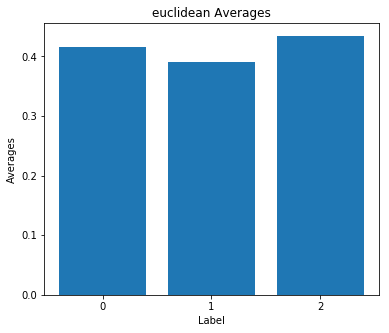

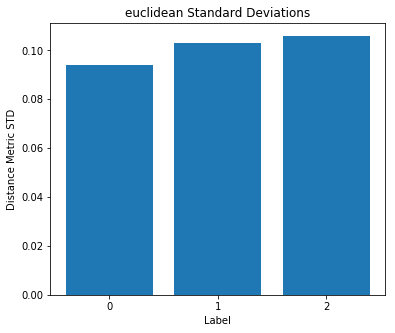

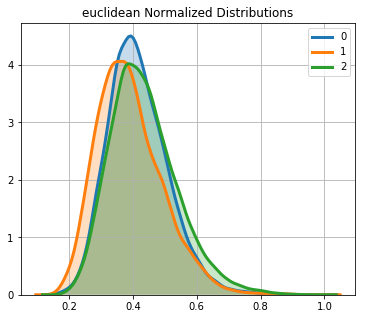

manhattan ORL
manhattan MEM
manhattan ATL
manhattan POR
manhattan SAC
manhattan MIL
manhattan OKC
manhattan BOS
manhattan MIA
manhattan UTA
manhattan LAC
manhattan SAS
manhattan CHO
manhattan IND
manhattan HOU
manhattan NYK
manhattan CHI
manhattan NOP
manhattan DAL
manhattan BRK
manhattan DET
manhattan LAL
manhattan WAS
manhattan MIN
manhattan PHO
manhattan DEN
manhattan CLE
manhattan PHI
manhattan GSW
manhattan TOR
Normalizing ...


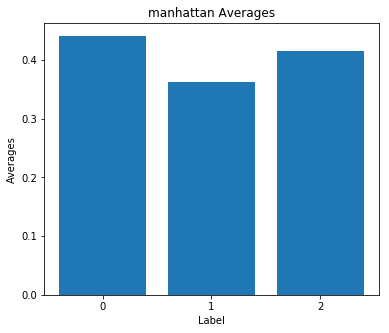

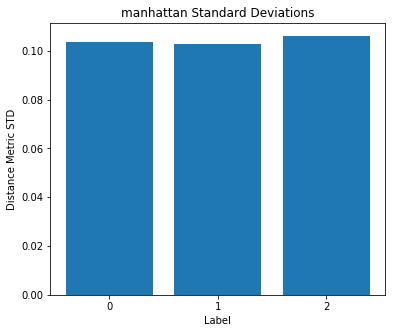

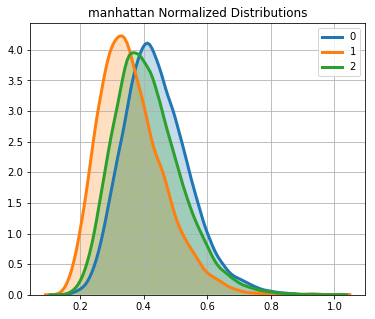

cosine ORL
cosine MEM
cosine ATL
cosine POR
cosine SAC
cosine MIL
cosine OKC
cosine BOS
cosine MIA
cosine UTA
cosine LAC
cosine SAS
cosine CHO
cosine IND
cosine HOU
cosine NYK
cosine CHI
cosine NOP
cosine DAL
cosine BRK
cosine DET
cosine LAL
cosine WAS
cosine MIN
cosine PHO
cosine DEN
cosine CLE
cosine PHI
cosine GSW
cosine TOR
Normalizing ...


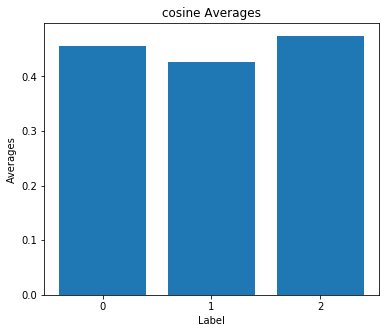

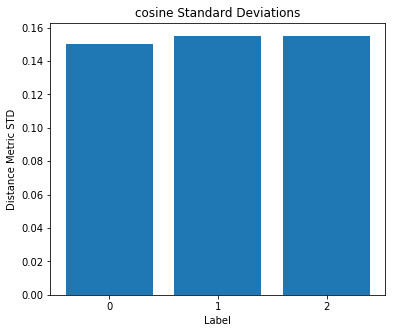

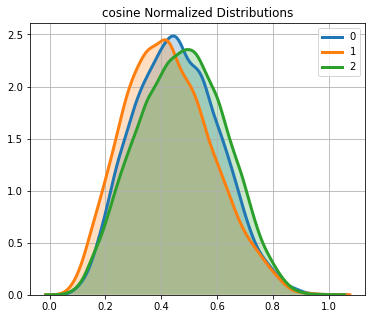

In [20]:
# Now we look at some pairs between draft players and teams
from sklearn.metrics import pairwise
figsize = (6,5)
metrics = ['euclidean', "manhattan", "cosine"]

for metric_name in metrics:

    metric = pairwise.distance_metrics()[metric_name] # This is a function 
    dist1, dist2, dist3 = [], [], []
    for team in scaledData['Tm'].unique():
        for year in scaledData["Year"].unique():
            teamYear = scaledData[(scaledData["Tm"]==team) & (scaledData["Year"]==year)]

            if len(teamYear)>1:

                # Get a draft player from the same yaer
                draftYear = scaledDraft[scaledDraft["Year"]==year]
                for i in range(len(draftYear)):
                    draftee = draftYear.iloc[i]
                    label = draftee["kmeans_label"]
                    teamMates = teamYear[teamYear['kmeans_label']==label] # potential teammates with same label

                    # Compute the metric
                    for j in range(len(teamMates)):
                        teamMate = teamMates.iloc[j]
                        dist = metric(draftee[simCols].to_numpy().reshape(1,-1),
                                      teamMate[simCols].to_numpy().reshape(1,-1)).item()
                        if label==0: dist1.append(dist)
                        elif label==1: dist2.append(dist)
                        else: dist3.append(dist)
        print(metric_name, team)
        
    # Normalize the results
    print("Normalizing ...")
    dist1,dist2,dist3 = [i/max(dist1) for i in dist1],[i/max(dist2) for i in dist2],[i/max(dist3) for i in dist3]
    
    # PLOT ALL OF THE STUFF FOR EACH METRIC
    
    # Plot the distance means
    plt.figure(figsize=figsize)
    plt.bar(range(3), [np.mean(dist1), np.mean(dist2), np.mean(dist3)])
    plt.xticks(range(3), ["0", "1", "2"])
    plt.xlabel("Label")
    plt.ylabel("Averages")
    plt.title("{} Averages".format(metric_name))
    plt.show()

    # Plot the standard devations
    plt.figure(figsize=figsize)
    plt.bar(range(3), [np.std(dist1), np.std(dist2), np.std(dist3)])
    plt.xticks(range(3), ["0", "1", "2"])
    plt.xlabel("Label")
    plt.ylabel("Distance Metric STD")
    plt.title("{} Standard Deviations".format(metric_name))
    plt.show()

    # Plot the distributions
    plt.figure(figsize=figsize)
    sns.distplot(dist1, hist=False, kde=True, kde_kws={'shade':True, 'linewidth':3}, label="0")
    sns.distplot(dist2, hist=False, kde=True, kde_kws={'shade':True, 'linewidth':3}, label="1")
    sns.distplot(dist3, hist=False, kde=True, kde_kws={'shade':True, 'linewidth':3}, label="2")
    plt.grid()
    plt.title("{} Normalized Distributions".format(metric_name))
    plt.show()

euclidean ORL
euclidean MEM
euclidean ATL
euclidean POR
euclidean SAC
euclidean MIL
euclidean OKC
euclidean BOS
euclidean MIA
euclidean UTA
euclidean LAC
euclidean SAS
euclidean CHO
euclidean IND
euclidean HOU
euclidean NYK
euclidean CHI
euclidean NOP
euclidean DAL
euclidean BRK
euclidean DET
euclidean LAL
euclidean WAS
euclidean MIN
euclidean PHO
euclidean DEN
euclidean CLE
euclidean PHI
euclidean GSW
euclidean TOR
Normalizing ...


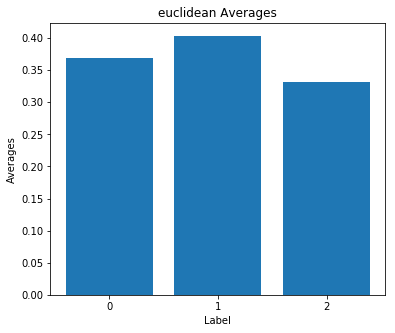

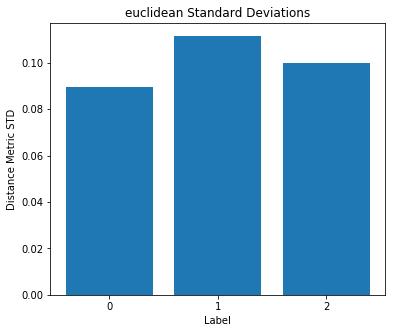

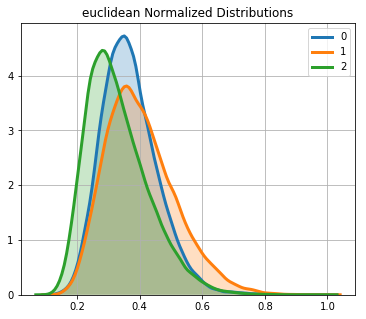

manhattan ORL
manhattan MEM
manhattan ATL
manhattan POR
manhattan SAC
manhattan MIL
manhattan OKC
manhattan BOS
manhattan MIA
manhattan UTA
manhattan LAC
manhattan SAS
manhattan CHO
manhattan IND
manhattan HOU
manhattan NYK
manhattan CHI
manhattan NOP
manhattan DAL
manhattan BRK
manhattan DET
manhattan LAL
manhattan WAS
manhattan MIN
manhattan PHO
manhattan DEN
manhattan CLE
manhattan PHI
manhattan GSW
manhattan TOR
Normalizing ...


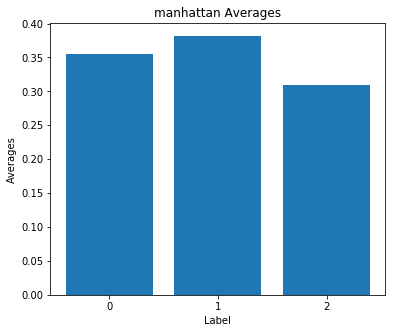

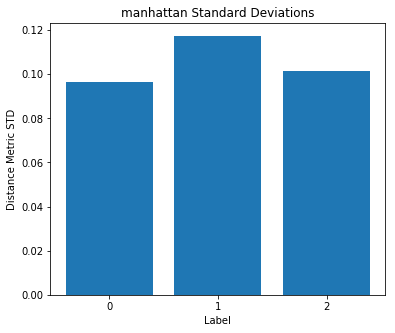

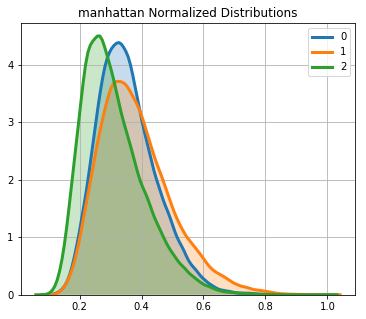

cosine ORL
cosine MEM
cosine ATL
cosine POR
cosine SAC
cosine MIL
cosine OKC
cosine BOS
cosine MIA
cosine UTA
cosine LAC
cosine SAS
cosine CHO
cosine IND
cosine HOU
cosine NYK
cosine CHI
cosine NOP
cosine DAL
cosine BRK
cosine DET
cosine LAL
cosine WAS
cosine MIN
cosine PHO
cosine DEN
cosine CLE
cosine PHI
cosine GSW
cosine TOR
Normalizing ...


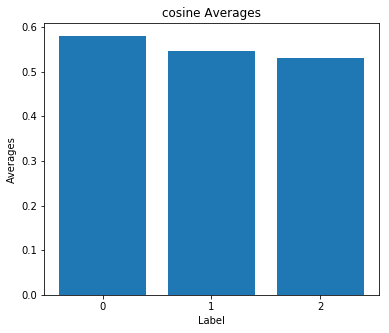

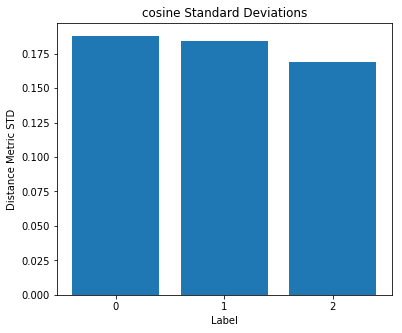

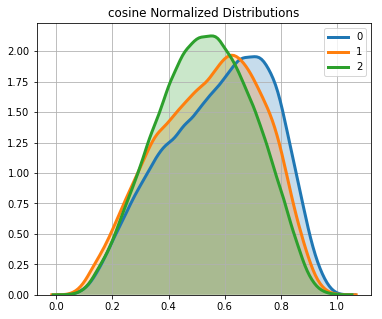

In [18]:
# Now we look at some pairs between draft players and teams
from sklearn.metrics import pairwise
figsize = (6,5)
metrics = ['euclidean', "manhattan", "cosine"]

for metric_name in metrics:

    metric = pairwise.distance_metrics()[metric_name] # This is a function 
    dist1, dist2, dist3 = [], [], []
    for team in scaledData['Tm'].unique():
        for year in scaledData["Year"].unique():
            teamYear = scaledData[(scaledData["Tm"]==team) & (scaledData["Year"]==year)]

            if len(teamYear)>1:

                # Get a draft player from the same yaer
                draftYear = scaledDraft[scaledDraft["Year"]==year]
                for i in range(len(draftYear)):
                    draftee = draftYear.iloc[i]
                    label = draftee["kmeans_label"]
                    # teamMates = teamYear[teamYear['kmeans_label']==label] # potential teammates with same label
                    teamMates = teamYear # THIS IS THE ONLY THING THAT CHANGES

                    # Compute the metric
                    for j in range(len(teamMates)):
                        teamMate = teamMates.iloc[j]
                        dist = metric(draftee[simCols].to_numpy().reshape(1,-1),
                                      teamMate[simCols].to_numpy().reshape(1,-1)).item()
                        if label==0: dist1.append(dist)
                        elif label==1: dist2.append(dist)
                        else: dist3.append(dist)
        print(metric_name, team)
        
    # Normalize the results
    print("Normalizing ...")
    dist1,dist2,dist3 = [i/max(dist1) for i in dist1],[i/max(dist2) for i in dist2],[i/max(dist3) for i in dist3]
    
    # PLOT ALL OF THE STUFF FOR EACH METRIC
    
    # Plot the distance means
    plt.figure(figsize=figsize)
    plt.bar(range(3), [np.mean(dist1), np.mean(dist2), np.mean(dist3)])
    plt.xticks(range(3), ["0", "1", "2"])
    plt.xlabel("Label")
    plt.ylabel("Averages")
    plt.title("{} Averages".format(metric_name))
    plt.show()

    # Plot the standard devations
    plt.figure(figsize=figsize)
    plt.bar(range(3), [np.std(dist1), np.std(dist2), np.std(dist3)])
    plt.xticks(range(3), ["0", "1", "2"])
    plt.xlabel("Label")
    plt.ylabel("Distance Metric STD")
    plt.title("{} Standard Deviations".format(metric_name))
    plt.show()

    # Plot the distributions
    plt.figure(figsize=figsize)
    sns.distplot(dist1, hist=False, kde=True, kde_kws={'shade':True, 'linewidth':3}, label="0")
    sns.distplot(dist2, hist=False, kde=True, kde_kws={'shade':True, 'linewidth':3}, label="1")
    sns.distplot(dist3, hist=False, kde=True, kde_kws={'shade':True, 'linewidth':3}, label="2")
    plt.grid()
    plt.title("{} Normalized Distributions".format(metric_name))
    plt.show()

euclidean ORL
euclidean MEM
euclidean ATL
euclidean POR
euclidean SAC
euclidean MIL
euclidean OKC
euclidean BOS
euclidean MIA
euclidean UTA
euclidean LAC
euclidean SAS
euclidean CHO
euclidean IND
euclidean HOU
euclidean NYK
euclidean CHI
euclidean NOP
euclidean DAL
euclidean BRK
euclidean DET
euclidean LAL
euclidean WAS
euclidean MIN
euclidean PHO
euclidean DEN
euclidean CLE
euclidean PHI
euclidean GSW
euclidean TOR
Normalizing ...


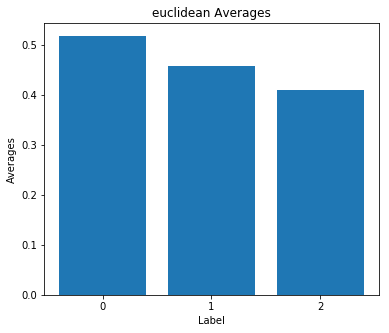

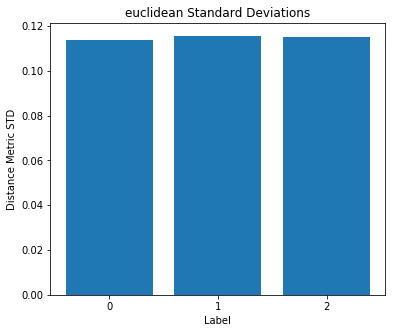

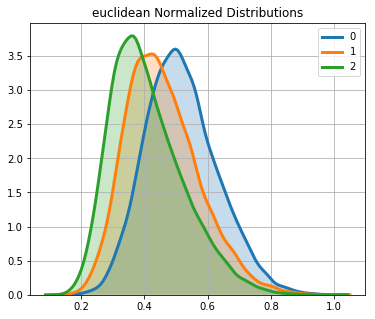

manhattan ORL
manhattan MEM
manhattan ATL
manhattan POR
manhattan SAC
manhattan MIL
manhattan OKC
manhattan BOS
manhattan MIA
manhattan UTA
manhattan LAC
manhattan SAS
manhattan CHO
manhattan IND
manhattan HOU
manhattan NYK
manhattan CHI
manhattan NOP
manhattan DAL
manhattan BRK
manhattan DET
manhattan LAL
manhattan WAS
manhattan MIN
manhattan PHO
manhattan DEN
manhattan CLE
manhattan PHI
manhattan GSW
manhattan TOR
Normalizing ...


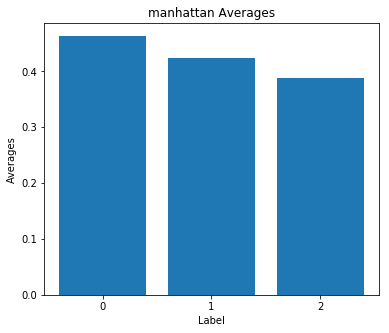

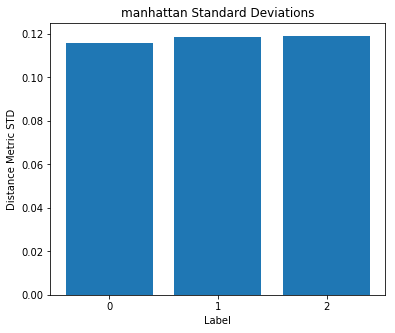

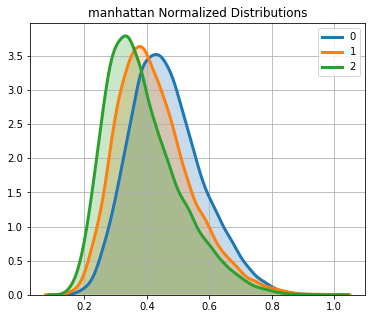

cosine ORL
cosine MEM
cosine ATL
cosine POR
cosine SAC
cosine MIL
cosine OKC
cosine BOS
cosine MIA
cosine UTA
cosine LAC
cosine SAS
cosine CHO
cosine IND
cosine HOU
cosine NYK
cosine CHI
cosine NOP
cosine DAL
cosine BRK
cosine DET
cosine LAL
cosine WAS
cosine MIN
cosine PHO
cosine DEN
cosine CLE
cosine PHI
cosine GSW
cosine TOR
Normalizing ...


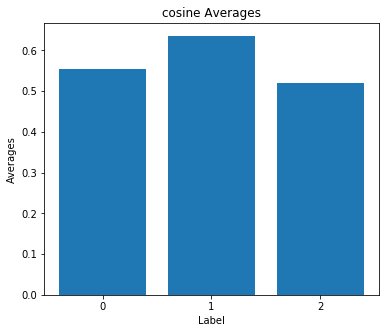

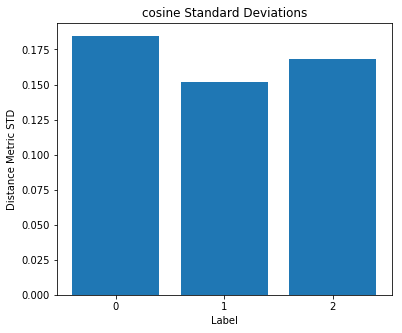

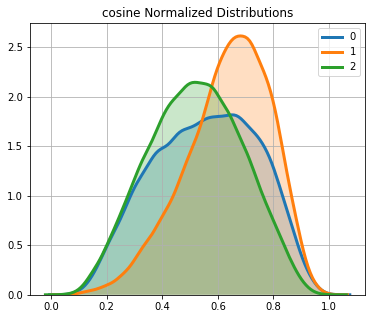

In [19]:
# DO THE SAME THING BUT WITH THE TOP 5 MINTUES PLAYERS
from sklearn.metrics import pairwise
figsize = (6,5)
metrics = ['euclidean', "manhattan", "cosine"]

for metric_name in metrics:

    metric = pairwise.distance_metrics()[metric_name] # This is a function 
    dist1, dist2, dist3 = [], [], []
    for team in scaledData['Tm'].unique():
        for year in scaledData["Year"].unique():
            teamYear = scaledData[(scaledData["Tm"]==team) & (scaledData["Year"]==year)]
            

            if len(teamYear)>5:
                teamYear = teamYear.sort_values(by=["MP"]).iloc[:5]

                # Get a draft player from the same yaer
                draftYear = scaledDraft[scaledDraft["Year"]==year]
                for i in range(len(draftYear)):
                    draftee = draftYear.iloc[i]
                    label = draftee["kmeans_label"]
                    # teamMates = teamYear[teamYear['kmeans_label']==label] # potential teammates with same label
                    teamMates = teamYear # THIS IS THE ONLY THING THAT CHANGES

                    # Compute the metric
                    for j in range(len(teamMates)):
                        teamMate = teamMates.iloc[j]
                        dist = metric(draftee[simCols].to_numpy().reshape(1,-1),
                                      teamMate[simCols].to_numpy().reshape(1,-1)).item()
                        if label==0: dist1.append(dist)
                        elif label==1: dist2.append(dist)
                        else: dist3.append(dist)
        print(metric_name, team)
        
    # Normalize the results
    print("Normalizing ...")
    dist1,dist2,dist3 = [i/max(dist1) for i in dist1],[i/max(dist2) for i in dist2],[i/max(dist3) for i in dist3]
    
    # PLOT ALL OF THE STUFF FOR EACH METRIC
    
    # Plot the distance means
    plt.figure(figsize=figsize)
    plt.bar(range(3), [np.mean(dist1), np.mean(dist2), np.mean(dist3)])
    plt.xticks(range(3), ["0", "1", "2"])
    plt.xlabel("Label")
    plt.ylabel("Averages")
    plt.title("{} Averages".format(metric_name))
    plt.show()

    # Plot the standard devations
    plt.figure(figsize=figsize)
    plt.bar(range(3), [np.std(dist1), np.std(dist2), np.std(dist3)])
    plt.xticks(range(3), ["0", "1", "2"])
    plt.xlabel("Label")
    plt.ylabel("Distance Metric STD")
    plt.title("{} Standard Deviations".format(metric_name))
    plt.show()

    # Plot the distributions
    plt.figure(figsize=figsize)
    sns.distplot(dist1, hist=False, kde=True, kde_kws={'shade':True, 'linewidth':3}, label="0")
    sns.distplot(dist2, hist=False, kde=True, kde_kws={'shade':True, 'linewidth':3}, label="1")
    sns.distplot(dist3, hist=False, kde=True, kde_kws={'shade':True, 'linewidth':3}, label="2")
    plt.grid()
    plt.title("{} Normalized Distributions".format(metric_name))
    plt.show()